<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 163
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   begin               159 non-null    datetime64[ns]     
 1   created             159 non-null    object             
 2   end                 159 non-null    datetime64[ns]     
 3   external_desc       159 non-null    object             
 4   modified            159 non-null    datetime64[ns, UTC]
 5   most-recent-update  159 non-null    object             
 6   number              159 non-null    int64              
 7   public              159 non-null    bool               
 8   service_key         159 non-null    object             
 9   service_name        159 non-null    object             
 10  severity            159 non-null    object             
 11  updates             159 non-null    object             
 12  uri                 159 non-null    

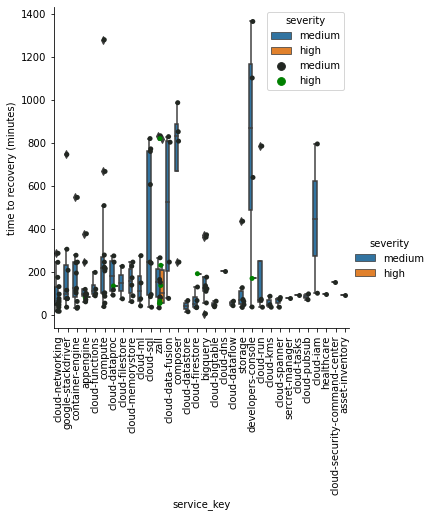

In [1]:
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

google_cloud_status_url = 'https://status.cloud.google.com/incidents.json'

response = json.loads(requests.get(google_cloud_status_url).text)

df = pd.read_json(google_cloud_status_url)

# remove the 'support' service_key as it's not relevant and skews the data
df = df[df.service_key != 'support']

df['cloud_provider'] = 'gcp'
df['begin'] = pd.to_datetime(df['begin'], format="%Y-%m-%dT%H:%M:%SZ")
df['end'] = pd.to_datetime(df['end'], format="%Y-%m-%dT%H:%M:%SZ")
df['duration'] = df['end'] - df['begin']
df['time_to_recovery'] = pd.to_numeric(df['duration'])\
                            .apply(lambda s: s / (10 ** 9) / 60)\
                            .astype(int)

print(df.info())
print(df.columns)
print(df.index)
print(df)

# grouping the dataset to perform aggregation functions
dfGroupedByServiceKeyAndSeverity = df \
                .groupby(['service_key', 'severity']) \
                .agg(
                    min_time_to_recovery=pd.NamedAgg(column="time_to_recovery", aggfunc="min"),
                    max_time_to_recovery=pd.NamedAgg(column="time_to_recovery", aggfunc="max"),
                    avg_time_to_recovery=pd.NamedAgg(column="time_to_recovery", aggfunc="mean"),
                    severity_count=pd.NamedAgg(column="severity", aggfunc="count"),
                ) \
                .astype(int) \
                .sort_values(by=['avg_time_to_recovery'], ascending=False)

print(dfGroupedByServiceKeyAndSeverity.info())
print(dfGroupedByServiceKeyAndSeverity.columns)
print(dfGroupedByServiceKeyAndSeverity.index)
print(dfGroupedByServiceKeyAndSeverity)

# plot the the dataset

ax = sns.catplot(
    data=df,
    x='service_key', y='time_to_recovery',
    kind='box', hue='severity'
)

ax = sns.stripplot(
    data=df,
    x='service_key', y='time_to_recovery',
    hue='severity', color='green'
)
ax.set(ylabel='time to recovery (minutes)')

plt.xticks(rotation=90)
plt.show()